<a href="https://colab.research.google.com/github/MRazin172/2348534_LLM_Project/blob/main/2348534_LLM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Installing the required libraries

In [1]:
!pip install sentence-transformers
!pip install ctransformers
!pip install pinecone-client
!pip install langchain
!pip install pypdf
!pip install python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.5/150.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found 

In [2]:
!pip install langchain_community
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.2 MB/s eta 0:00:00


In [3]:
model_name_or_path = "TheBloke/Llama-2-7B-Chat-GGML"
model_basename = "llama-2-7b-chat.ggmlv3.q4_0.bin" # the model is in bin format

here we are specifying the name of the pre trained model which i have chosen is Llama. The Llama model is provides the TheBoke organization.

The sppecific version of Llama that i am using is Llama-2-7B-Chat-GGML. this specific version is pretrained on 7Billion parameters and the Chat indicates that the model is suitable for conversational tasks, making it suitable for a chatbot application.

the model basename is given in .bin format.
the model is taken in as a quantized format

In [4]:
from huggingface_hub import hf_hub_download
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-7b-chat.ggmlv3.q4_0.bin:   0%|          | 0.00/3.79G [00:00<?, ?B/s]

importing the huggingface hub

then the model path is set to download the model from the hugging face repository using the hf_hub_download function

In [5]:
book_link = "https://ia804601.us.archive.org/30/items/GaleEncyclopediaOfAlternativeMedicine2ndEdition.Vol.1AC/Gale%20Encyclopedia%20of%20Alternative%20Medicine,%202nd%20Edition.%20Vol.%201,%20A-C.pdf"

this is the medical encyclopedia containing medical data on which our llama model will be fine tuned on

In [6]:
import os
import requests

# Create a 'pdfs' folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# URL of the PDF you want to download
pdf_url = book_link

# Get the filename from the URL
filename = pdf_url.split("/")[-1]

# Full path where the PDF will be saved
save_path = os.path.join('data', filename)

# Download the PDF
response = requests.get(pdf_url)

# Check if the request was successful
if response.status_code == 200:
    # Write the content to a file
    with open(save_path, 'wb') as file:
        file.write(response.content)
    print(f"PDF downloaded and saved to {save_path}")
else:
    print(f"Failed to download PDF. Status code: {response.status_code}")

PDF downloaded and saved to data/Gale%20Encyclopedia%20of%20Alternative%20Medicine,%202nd%20Edition.%20Vol.%201,%20A-C.pdf


creating a directory for downloading and saving the book as pdf

In [7]:
from langchain import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Pinecone
import pinecone
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.llms import CTransformers

In [22]:
PINECONE_API_KEY="1446a3fc-441d-4dc6-befc-aa31b939bfdf"
PINECONE_API_ENV="starter"

PINECONE_API_KEY: This is the API key used to authenticate our requests to the Pinecone service. It's a unique identifier that grants access to our Pinecone account and resources.

PINECONE_API_ENV: This specifies the environment we r working in within Pinecone.


**the api key is named as medicur**

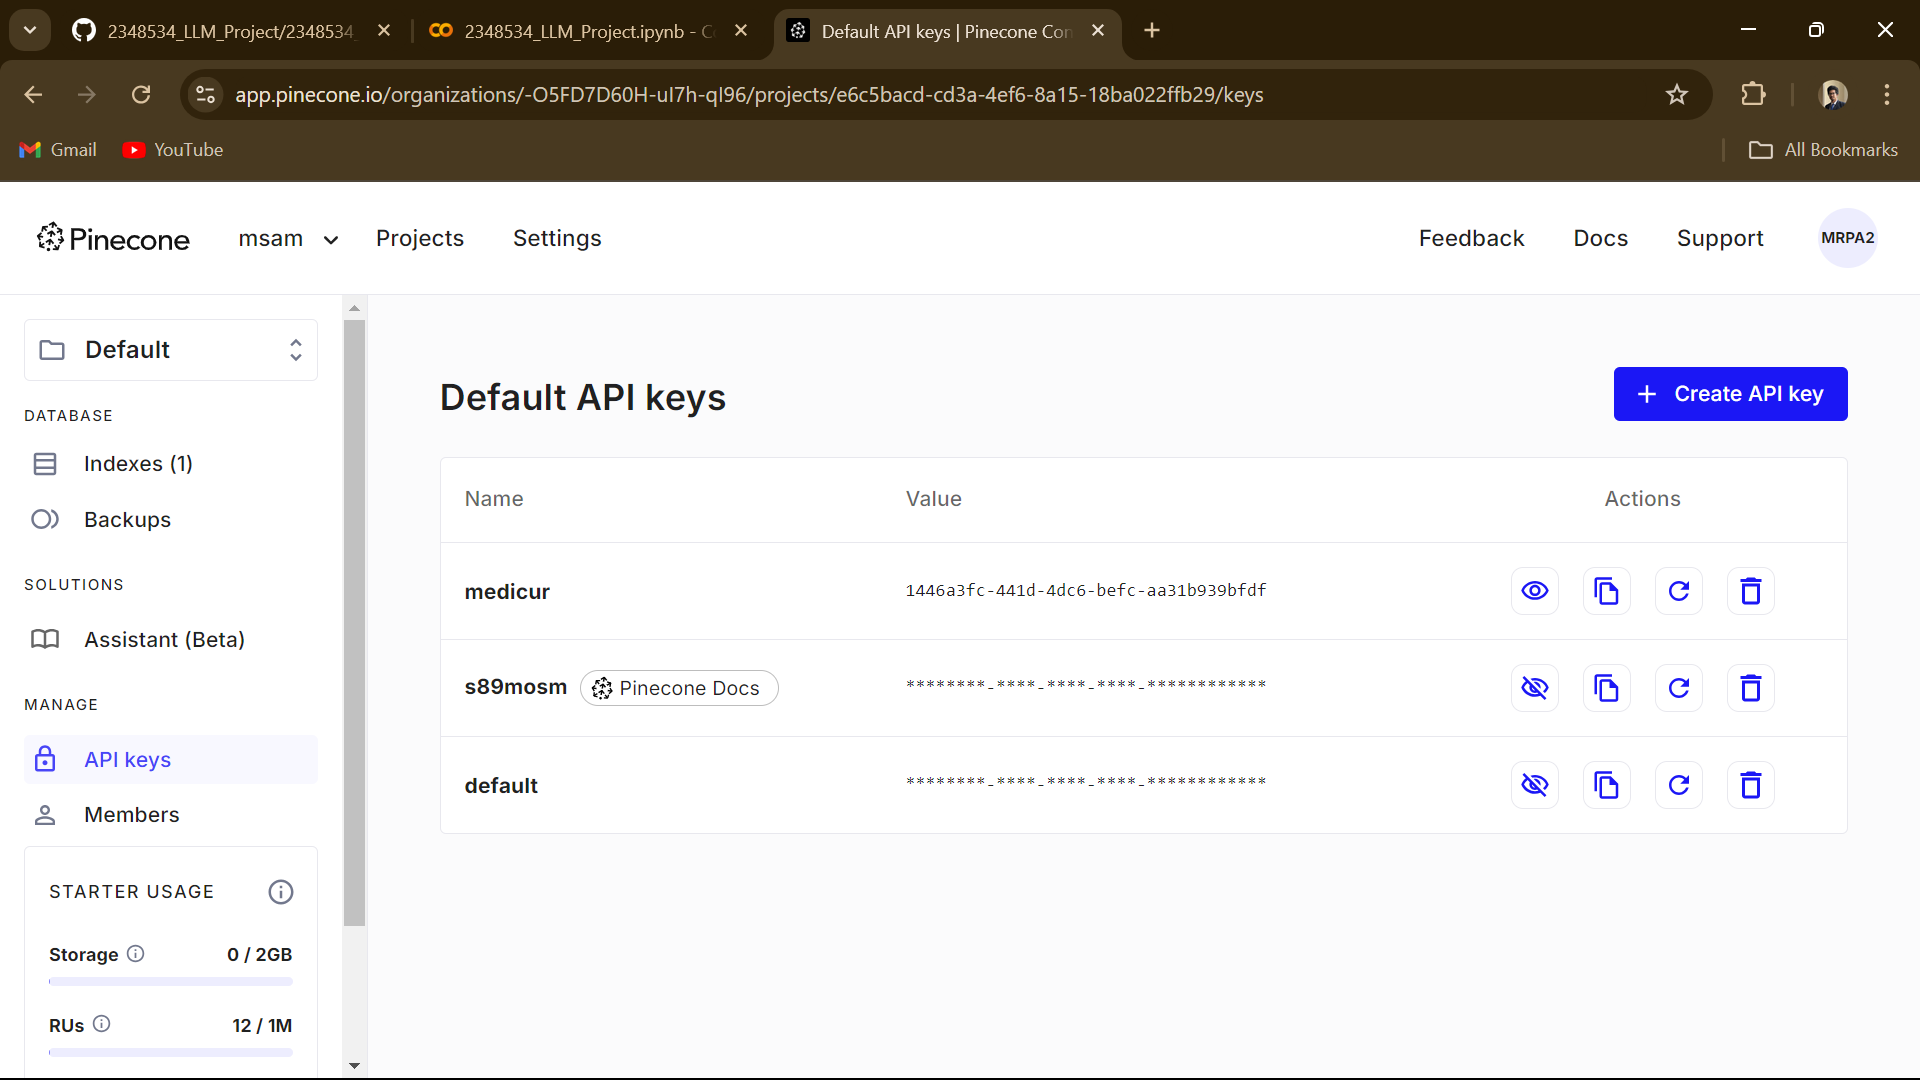

In [9]:
from langchain.document_loaders import PyPDFDirectoryLoader


importing the pdf loader to read and load the pdf file

In [10]:
loader = PyPDFDirectoryLoader("data")


loading all PDF files from directory so that their contents can be processed or analyzed by your application.

sets up a tool to automatically read all PDF files in the data folder

In [11]:
!pip install pypdf


In [12]:
extracted_data = loader.load()


load the content of all the PDF files from the directory specified earlier.

gathering all the text content from the PDF files in your specified directory

In [13]:
#Create text chunks
def text_split(extracted_data):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 20)
    text_chunks = text_splitter.split_documents(extracted_data)

    return text_chunks

function to extract data from the downloaded pdf

then spliting the data into smaller chunks of size 500 characters with a chunke overlap of 20. this parameter defines that consecutive chunks will overlap by 20 characters. The overlap ensures that no information is lost between chunks, which is particularly useful in maintaining context in the text.

In [14]:
text_chunks = text_split(extracted_data)
print("length of my chunk:", len(text_chunks))

length of my chunk: 6918


text_chunks: This variable holds the list of text chunks generated by the text_split function. Each chunk is a smaller segment of the original extracted text.

len(text_chunks): This function returns the number of elements in the text_chunks list. In this case, it gives you the number of text chunks that were created from the original extracted_data.

In [15]:
#download embedding model
def download_hugging_face_embeddings():
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return embeddings

downloads the model from the Hugging Face Model Hub.

This model, "sentence-transformers/all-MiniLM-L6-v2", is used to convert sentences into numerical vectors

In [16]:
embeddings = download_hugging_face_embeddings()


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

download and return an embedding model from Hugging Face.

In [17]:
embeddings


HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [18]:
query_result = embeddings.embed_query("Hello world")
print("Length", len(query_result))

Length 384


In [33]:
index_name="medical-chatbot"


here i am creating an index named as medical-chatbot.

index in Pinecone is a data structure that stores high-dimensional vector representations (embeddings) of your data.  

In [20]:
!pip install --upgrade langchain-pinecone


 upgradeing the langchain-pinecone package to the latest version

In [25]:
pinecone.init

<function pinecone.deprecation_warnings.init(*args, **kwargs)>

here i am initializing the Pinecone environment in your Python script

it helps to set up the connection to my Pinecone account

It uses my Pinecone API key to authenticate your requests.
configuring the environment (e.g., region) where your Pinecone index will be hosted.

Once initialized, we can perform operations like creating indexes

In [34]:
import os
from pinecone import Pinecone, ServerlessSpec

# Initialize Pinecone using the Pinecone class
pc = Pinecone(
    api_key=PINECONE_API_KEY
)

# Check if the index already exists
if index_name not in pc.list_indexes().names():
    # Create an index with the desired name and dimension
    pc.create_index(
        name=index_name,
        dimension=384 ,  # Adjust dimension based on your embeddings
        spec=ServerlessSpec(
            cloud='aws',  # Specify cloud provider, e.g., 'aws'
            region='us-east-1'  # Try using a region like 'us-east-1'
        )
    )

# Connect to the created index
index = pc.Index(index_name)
print(f"Index '{index_name}' created and connected.")


Index 'medical-chatbot' created and connected.


here what i am doing is
  first i am importing the nceessary libraries in oreder to connect to the pinecone env and services

  i am initializing the api key that i  have created in my pinecone account. this key is stored in the variable api_key.

  then i have to create an index in my acconut to store the vector embedded data
  createing one with the specified name (index_name) and a dimensionality of 384. The ServerlessSpec is used to define the cloud provider (aws) and the region (us-east-1), which are necessary for hosting the index.

  Once the index is created we connect to it by creating an Index object.





Initialize Pinecone client with API key

Access a specific Pinecone index


In [36]:
index = pc.Index(index_name)
print(f"Index '{index_name}' connected.")

Index 'medical-chatbot' connected.


printing the index name which was created for verifying

In [37]:
embedded_texts = embeddings.embed_documents([t.page_content for t in text_chunks])

# Prepare vectors for upsert
vectors_to_upsert = []
for i, (chunk, embedding) in enumerate(zip(text_chunks, embedded_texts)):
    vector = {
        "id": f"chunk_{i}",
        "values": embedding,
        "metadata": {
            "text": chunk.page_content,
            # Add any other metadata you want to include
        }
    }
    vectors_to_upsert.append(vector)

# Function to split list into chunks
def chunk_list(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

# Split vectors into smaller batches
batch_size = 100  # You might need to adjust this
batches = chunk_list(vectors_to_upsert, batch_size)

# Upsert batches to Pinecone
for i, batch in enumerate(batches):
    try:
        index.upsert(
            vectors=batch,
            namespace="ns1"  # Replace with your desired namespace
        )
        print(f"Batch {i+1}/{len(batches)} upserted successfully")
    except Exception as e:
        print(f"Error upserting batch {i+1}: {str(e)}")
        # You might want to implement retry logic here

print("Upsert completed")

Batch 1/70 upserted successfully
Batch 2/70 upserted successfully
Batch 3/70 upserted successfully
Batch 4/70 upserted successfully
Batch 5/70 upserted successfully
Batch 6/70 upserted successfully
Batch 7/70 upserted successfully
Batch 8/70 upserted successfully
Batch 9/70 upserted successfully
Batch 10/70 upserted successfully
Batch 11/70 upserted successfully
Batch 12/70 upserted successfully
Batch 13/70 upserted successfully
Batch 14/70 upserted successfully
Batch 15/70 upserted successfully
Batch 16/70 upserted successfully
Batch 17/70 upserted successfully
Batch 18/70 upserted successfully
Batch 19/70 upserted successfully
Batch 20/70 upserted successfully
Batch 21/70 upserted successfully
Batch 22/70 upserted successfully
Batch 23/70 upserted successfully
Batch 24/70 upserted successfully
Batch 25/70 upserted successfully
Batch 26/70 upserted successfully
Batch 27/70 upserted successfully
Batch 28/70 upserted successfully
Batch 29/70 upserted successfully
Batch 30/70 upserted su

First, it converts text chunks into vectors using a Hugging Face embedding model.

It then prepares these vectors by creating a list with unique IDs and metadata.

Add vectors to the Pinecone index in batches, with error handling to ensure reliability.

To manage large uploads, it splits the vectors into smaller batches and uploads them to Pinecone, handling any errors that occur. This approach ensures efficient and organized storage of data in Pinecone, enabling effective vector-based searches.

In [39]:
query = "What is aids"

# Generate embedding for the query
query_embedding = embeddings.embed_query(query)

# Perform similarity search
search_results = index.query(
    namespace="ns1",  # Replace with your actual namespace
    vector=query_embedding,
    top_k=1,  # Number of results you want
    include_values=True,
    include_metadata=True
)

# Process and print results
print("Results:")
for match in search_results['matches']:
    print(f"ID: {match['id']}")
    print(f"Score: {match['score']}")
    print(f"Metadata: {match['metadata']}")
    print("---")

Results:
ID: chunk_415
Score: 0.780964911
Metadata: {'text': 'Ken WellsAIDS\nDefinition\nAcquired immune deficiency syndrome (AIDS) is\nan infectious disease caused by the human immunodefi-ciency virus (HIV). It was first recognized in the UnitedStates in 1981. AIDS is the advanced form of infectionwith the HIV virus, which may not cause disease for along period after the initial exposure (latency). Infectionwith HIV weakens the immune system which makes in-fected people susceptible to infection and cancer .\nDescription'}
---


here i am performing a similarity search using a query in a Pinecone index.

additonally here we are testing the finetuned model with a query of our choice

the query can be any question or any doubt from the medical field.
